# Preparation

### Import, constants and functions

In [1]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [4]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [5]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [6]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [7]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [8]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    5389 samples
Test set:     1348 samples
Sample dims:  (5389, 108, 192, 3)


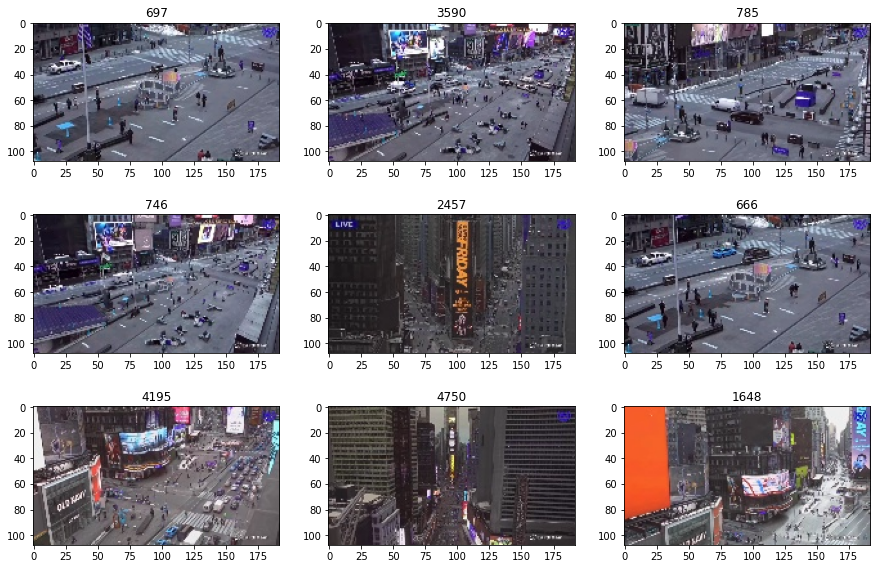

In [9]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [10]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [11]:
latent_dim = 5000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(width*hight*3, activation='sigmoid'),
      layers.Reshape((hight, width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [13]:
epochs = 50
batch_size = 32
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/50
169/169 [==============================] - 24s 139ms/step - loss: 0.0421 - accuracy: 0.5131 - val_loss: 0.0365 - val_accuracy: 0.3896
Epoch 2/50
169/169 [==============================] - 23s 138ms/step - loss: 0.0325 - accuracy: 0.6238 - val_loss: 0.0295 - val_accuracy: 0.6753
Epoch 3/50
169/169 [==============================] - 23s 138ms/step - loss: 0.0293 - accuracy: 0.6942 - val_loss: 0.0322 - val_accuracy: 0.6754
Epoch 4/50
169/169 [==============================] - 23s 138ms/step - loss: 0.0301 - accuracy: 0.7079 - val_loss: 0.0267 - val_accuracy: 0.7272
Epoch 5/50
169/169 [==============================] - 23s 138ms/step - loss: 0.0275 - accuracy: 0.7224 - val_loss: 0.0275 - val_accuracy: 0.7136
Epoch 6/50
169/169 [==============================] - 23s 137ms/step - loss: 0.0291 - accuracy: 0.7037 - val_loss: 0.0267 - val_accuracy: 0.7248
Epoch 7/50
169/169 [==============================] - 23s 138ms/step - loss: 0.0268 - accuracy: 0.7241 - val_loss: 0.0258 - val_ac

Train Acc      0.6463529467582703
Validation Acc 0.6467217206954956


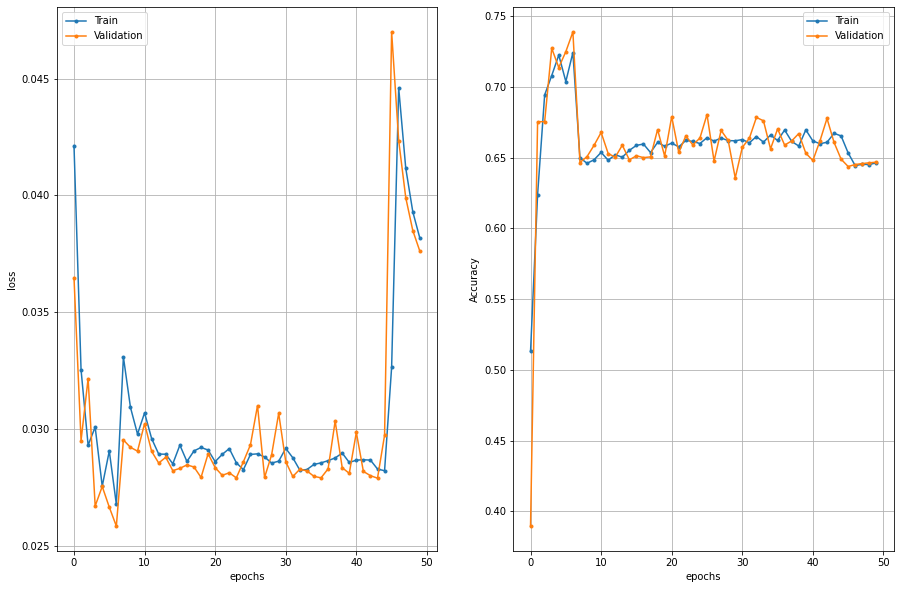

In [14]:
show_results(history)

Train Acc      0.6463529467582703
Validation Acc 0.6467217206954956


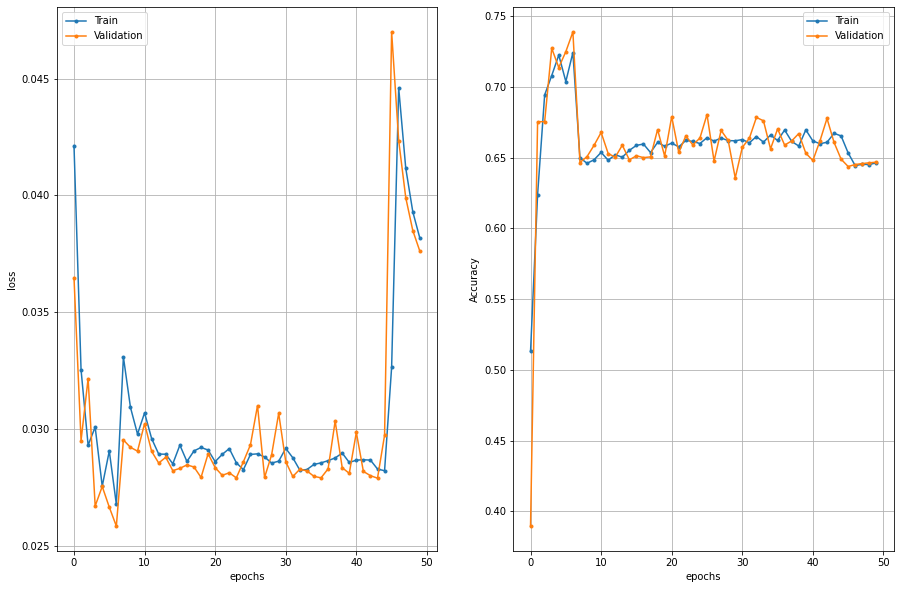

In [15]:
show_results(history)

In [16]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [17]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1348, 5000)
Sample decoded:  (1348, 108, 192, 3)
comression:  12.4416


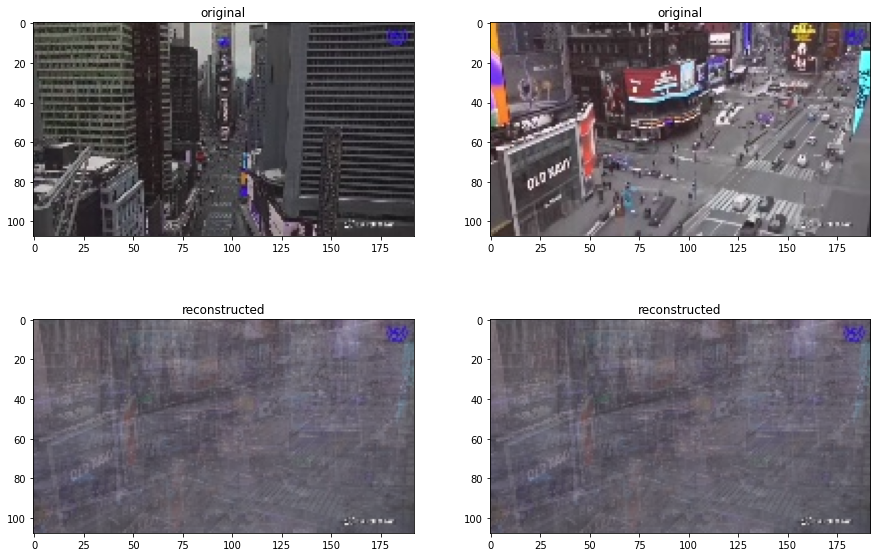

In [18]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)